In [ ]:
import os
import pandas as pd
#SparkContext().stop()
#sc = SparkContext('local')
#spark = SparkSession(sc)
# to read parquet file
path = 'C:/Users/bnsha_000/Desktop/Data Analysis/AirlineDelays/1_Data/'

filelist = os.listdir(path+'csvs/')
csv_file = path + 'csvs/Fdelay_Data_1.csv'
parquet_path = path + 'parquet3/'
#df = sqlContext.read.parquet(path)

for file in filelist:
    print(file)
    df = sqlContext.read.format("com.databricks.spark.csv")\
        .option("header", "true")\
        .option("inferschema", "true")\
        .option("mode", "DROPMALFORMED")\
        .load(path+'csvs/'+file)
    df = df.drop("Unnamed: 47")
    df.write.mode("append").format("parquet").option("compression", "snappy").save(parquet_path)

In [1]:
read_path = 'C:/Users/bnsha_000/Desktop/Data Analysis/AirlineDelays/1_Data/parquet3/'

df = sqlContext.read.parquet(read_path)
sqlContext.registerDataFrameAsTable(df, "df")
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- FL_DATE: timestamp (nullable = true)
 |-- UNIQUE_CARRIER: string (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT_SEQ_ID: integer (nullable = true)
 |-- ORIGIN_CITY_MARKET_ID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY_NAME: string (nullable = true)
 |-- ORIGIN_STATE_NM: string (nullable = true)
 |-- ORIGIN_WAC: integer (nullable = true)
 |-- DEST_AIRPORT_SEQ_ID: integer (nullable = true)
 |-- DEST_CITY_MARKET_ID: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY_NAME: string (nullable = true)
 |-- DEST_STATE_NM: string (nullable = true)
 |-- DEST_WAC: integer (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (null

In [7]:
col_list = ['YEAR','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','TAIL_NUM','FL_NUM','ORIGIN',
            'ORIGIN_CITY_NAME','DEST','DEST_CITY_NAME','CRS_DEP_TIME''CRS_ARR_TIME','DEP_DELAY','ARR_DELAY',
            'TAXI_IN','TAXI_OUT','CANCELLED','CANCELLATION_CODE','AIR_TIME','DISTANCE',
            'CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']

### Carrier Statistics

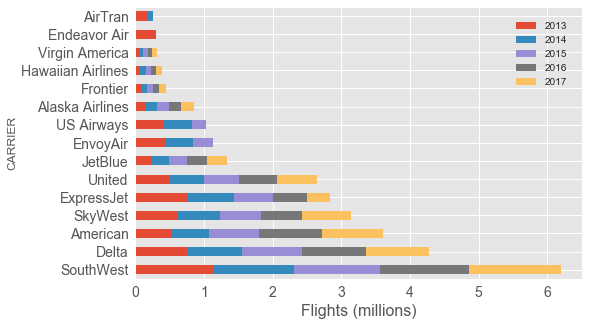

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
airlines_dict = {'WN':'SouthWest','DL':'Delta','AA':'American','OO':'SkyWest','EV':'ExpressJet',
                 'UA':'United','B6':'JetBlue','MQ':'EnvoyAir','US':'US Airways','AS':'Alaska Airlines',
                '9E':'Endeavor Air','F9':'Frontier','FL':'AirTran','HA':'Hawaiian Airlines',
                'VX':'Virgin America','YV':'Mesa Airlines'}

num_df = sqlContext.sql("SELECT UNIQUE_CARRIER AS AIRLINE,YEAR, COUNT(CRS_DEP_TIME)/1000000 AS Flights \
                         FROM df WHERE YEAR >=2013 AND YEAR<=2017 GROUP BY UNIQUE_CARRIER,YEAR ORDER BY \
                        UNIQUE_CARRIER,YEAR,COUNT(CRS_DEP_TIME) DESC").toPandas()

num_df['CARRIER'] = num_df['AIRLINE'].map(airlines_dict)
top10_df = num_df.groupby(['YEAR']).apply(lambda x: x.sort_values(["Flights"],ascending=False))
top10_df.reset_index(drop = True, inplace = True)

f,ax = plt.subplots(figsize=(8,5))
pivot_df = top10_df.pivot_table(index='CARRIER', columns='YEAR', values='Flights')
pivot_df['sum'] = pivot_df.sum(axis=1)
plot_df = pivot_df.sort_values(by=['sum'],ascending=False).head(15)
del plot_df['sum']
plot_df.plot.barh(stacked=True,ax=ax)
ax.set_xlabel('Flights (millions)',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(loc=1, prop={'size': 12})
plt.show()

### Departure Delay

In [18]:
delay_df = sqlContext.sql("SELECT UNIQUE_CARRIER AS AIRLINE,YEAR, CEIL(DEP_DELAY/5)*5 AS DEPT_DELAY\
                         FROM df WHERE YEAR >=2013 AND YEAR<=2017 AND DEP_DELAY>0")

filt_df = delay_df.drop_duplicates(subset=['AIRLINE','YEAR','DEPT_DELAY']).toPandas()
filt_df['CARRIER'] = filt_df['AIRLINE'].map(airlines_dict)

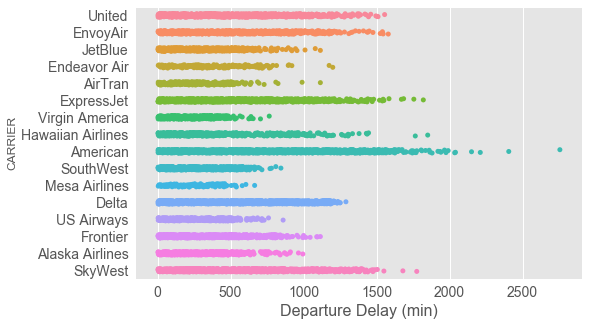

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
f1,ax1 = plt.subplots(figsize=(8,5))

ax1 = sns.stripplot(x="DEPT_DELAY", y="CARRIER", data=filt_df, jitter=True)
ax1.set_xlabel('Departure Delay (min)',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

### Arrival Delay

In [20]:
delay_df = sqlContext.sql("SELECT UNIQUE_CARRIER AS AIRLINE,YEAR, CEIL(ARR_DELAY/5)*5 AS ARRVL_DELAY\
                         FROM df WHERE YEAR >=2013 AND YEAR<=2017 AND ARR_DELAY>0")

filt_df = delay_df.drop_duplicates(subset=['AIRLINE','YEAR','ARRVL_DELAY']).toPandas()
filt_df['CARRIER'] = filt_df['AIRLINE'].map(airlines_dict)

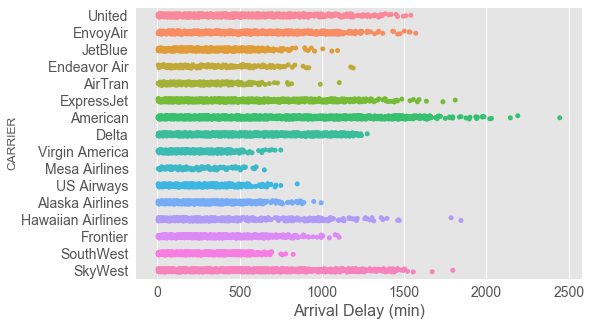

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
f1,ax1 = plt.subplots(figsize=(8,5))
ax1 = sns.stripplot(x="ARRVL_DELAY", y="CARRIER",data=filt_df, jitter=True)
ax1.set_xlabel('Arrival Delay (min)',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

### Airports

In [ ]:
ap_df = sqlContext.sql("SELECT ORIGIN AS AIRPORT,YEAR, COUNT(CRS_DEP_TIME)/100000 AS Flights \
                         FROM df WHERE YEAR >=2013 AND YEAR<=2017 GROUP BY ORIGN,YEAR ORDER BY \
                        ORIGIN,YEAR,COUNT(CRS_DEP_TIME) DESC").toPandas()

ap_database = pd.read_csv('airports.dat')
col_list = ['index','airport','city','country','IATA','ICAO','LAT','LON','Code','Loc','Type','Source']
ap_database.columns = col_list
merge_df = pd.merge(ap_df,ap_database,left_on=['AIRPORT'],right_on=['IATA'],how='left')




In [14]:
Top20_airports = num_df['AIRPORT'].tolist()

In [28]:
df_filt = df.filter(df.YEAR>2012)
df_Top20 = df_filt.filter(df.ORIGIN.isin(Top20_airports))
sqlContext.registerDataFrameAsTable(df_Top20, "df_Top20")
delay_df = sqlContext.sql("SELECT ORIGIN_CITY_NAME AS AIRPORT, CEIL(DEP_DELAY/100)*100 AS DEPT_DELAY, \
                            COUNT(1) AS OCCURENCES \
                          FROM df_Top20 WHERE DEP_DELAY>0 GROUP BY ORIGIN_CITY_NAME, CEIL(DEP_DELAY/100)*100 \
                          ORDER BY ORIGIN_CITY_NAME, CEIL(DEP_DELAY/100)*100 ASC").toPandas()

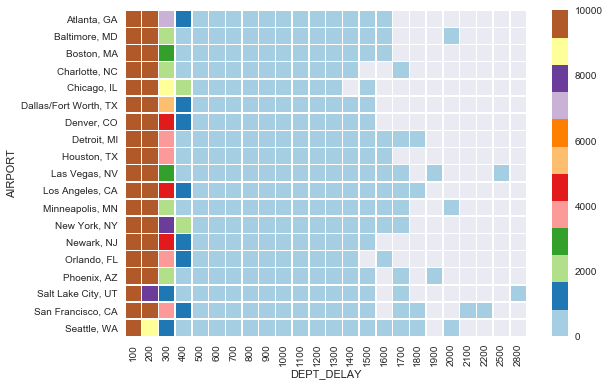

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
#fig,ax3 = plt.subplots(figsize=(10,6))
delay_df['AIRPORT'] = delay_df['AIRPORT'].astype(str)
delay_df['DEPT_DELAY'] = delay_df['DEPT_DELAY'].astype(int)
delay_df['OCCURENCES'] = delay_df['OCCURENCES'].astype(int)
delay_df = delay_df.dropna()
delay_filt = delay_df.pivot("AIRPORT", "DEPT_DELAY", "OCCURENCES")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(delay_filt, annot=False, linewidths=.5, ax=ax,vmin=0,vmax=10000,cmap='Paired')
plt.show()
# ax3 = sns.stripplot(y="AIRPORT", x="DEPARTURE_DELAY", size = 4, palette = colors,
#                     data=delay_df, linewidth = 0.5,  jitter=True)
# plt.setp(ax3.get_xticklabels(), fontsize=14)
# plt.setp(ax3.get_yticklabels(), fontsize=14)
# ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
#                          for x in ax3.get_xticks()])
# plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
#            color='w', labelpad=20)
# ax3.yaxis.label.set_visible(False)
# #________________________
# plt.tight_layout(w_pad=3) 

In [30]:
delay_filt.head()

DEPT_DELAY,100,200,300,400,500,600,700,800,900,1000,...,1500,1600,1700,1800,1900,2000,2100,2200,2500,2800
AIRPORT,,,,,,,,,,,,,,,,,,,,,
"Atlanta, GA",679946.0,36607.0,7110.0,1586.0,464.0,313.0,217.0,138.0,96.0,68.0,...,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Baltimore, MD",216605.0,10100.0,2205.0,565.0,121.0,28.0,10.0,21.0,22.0,14.0,...,1.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
"Boston, MA",196414.0,14314.0,3016.0,812.0,230.0,78.0,30.0,37.0,33.0,25.0,...,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Charlotte, NC",208637.0,11662.0,1918.0,438.0,99.0,50.0,26.0,32.0,44.0,20.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Chicago, IL",559595.0,46211.0,8644.0,1777.0,463.0,201.0,123.0,130.0,115.0,54.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
%%spark -c sql -o df_hvac --maxrows 10
SELECT a.*, 
       b.Flights 
FROM 
    (SELECT ORIGIN, ORIGIN_CITY_NAME,AVG(DEP_DELAY) AS Departure_Delay,COUNT(*) AS Delay_Flights
     FROM df a
     WHERE DEP_DELAY > 15.0 
     GROUP BY ORIGIN,ORIGIN_CITY_NAME) 
     LEFT JOIN 
    (SELECT ORIGIN,ORIGIN_CITY_NAME,COUNT(*) AS Flights 
     FROM df b
     GROUP BY ORIGIN,ORIGIN_CITY_NAME) 
ON a.ORIGIN = b.ORIGIN 
AND a.ORIGIN_CITY_NAME = b.ORIGIN_CITY_NAME

An error was encountered:
You need to have at least 1 client created to execute commands.


In [15]:
%%spark -c sql -o df_hvac --maxrows 10

sqlDF = sqlContext.sql("SELECT a.*, b.Flights FROM \
                       ((SELECT ORIGIN, \
                                ORIGIN_CITY_NAME,\
                                AVG(DEP_DELAY) AS Departure_Delay, \
                                COUNT(*) AS Delay_Flights\
                         FROM df \
                         WHERE DEP_DELAY > 15.0 \
                         GROUP BY ORIGIN,ORIGIN_CITY_NAME) a \
                         LEFT JOIN \
                         (SELECT ORIGIN, \
                                 ORIGIN_CITY_NAME, \
                                 COUNT(*) AS Flights FROM df GROUP BY ORIGIN,ORIGIN_CITY_NAME) b 
                          ON a.ORIGIN = b.ORIGIN \
                          AND a.ORIGIN_CITY_NAME = b.ORIGIN_CITY_NAME)").toPandas()
sqlDF.head()

SyntaxError: EOL while scanning string literal (<ipython-input-15-e65d97d377c7>, line 1)